In [144]:
import multiprocessing as mp
import typing
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import scipy as sp
import sklearn.utils
from tqdm import tqdm

from IPython import get_ipython  # For automatically-generated python file.

In [145]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
def get_random_number_for_right_deck(n: int, seed: int=None, ) -> int:
    """
    Return the number of cards to split into the right sub-deck.

    :param n: one above the highest number that could be returned by this
              function.
    :param seed: optional seed for the random number generator to enable
                 deterministic behavior.
    :return: a random integer (between 1 and n-1) that represents the
             desired number of cards.

    Examples:

    >>> get_random_number_for_right_deck(n=5, seed=0, )
    1
    """
    random = sklearn.utils.check_random_state(seed=seed, )
    
    return random.randint(low=1, high=n, )

In [147]:
def should_drop_from_right_deck(n_left: int, n_right:int, seed: int=None, ) -> bool:
    """
    Determine whether we drop a card from the right or left sub-deck.
    
    Either `n_left` or `n_right` (or both) must be greater than zero.
    
    :param n_left: the number of cards in the left sub-deck.
    :param n_right: the number of cards in the right sub-deck.
    :param seed: optional seed for the random number generator to
                 enable deterministic behavior.
    :return: True if we should drop a card from the right sub-deck,
             False otherwise.
    
    Examples:

    >>> should_drop_from_right_deck(n_left=32, n_right=5, seed=0, )
    True

    >>> should_drop_from_right_deck(n_left=0, n_right=5, )
    True

    >>> should_drop_from_right_deck(n_left=7, n_right=0, )
    False

    >>> should_drop_from_right_deck(n_left=0, n_right=0, )
    Traceback (most recent call last):
    ...
    ValueError: Either `n_left` or `n_right` (or both) must be greater than zero.
    """
    if n_left > 0 and n_right > 0:
        # There are cards left in both sub-decks, so pick a
        # sub-deck at random.
        random = sklearn.utils.check_random_state(seed=seed, )
        num = random.randint(low=0, high=2, )
        boolean = (num == 0)
        return boolean
    elif n_left == 0 and n_right > 0:
        # There are no more cards in the left sub-deck, only
        # the right sub-deck, so we drop from the right sub-deck.
        return True
    elif n_left > 0 and n_right == 0:
        # There are no more cards in the right sub-deck, only
        # the left sub-deck, so we drop from the left sub-deck.
        return False
    else:
        # There are no more cards in either sub-deck.
        raise ValueError ('Either `n_left` or `n_right` '\
                          '(or both) must be greater than zero.')

In [148]:
def shuffle(deck: np.array, seed: int=None, ) -> np.array:
    """
    Shuffle the input 'deck' using the Gilbert–Shannon–Reeds method.

    :param seq: the input sequence of integers.
    :param seed: optional seed for the random number generator
                 to enable deterministic behavior.
    :return: A new deck containing shuffled integers from the
             input deck.

    Examples:

    >>> shuffle(deck=np.array([0, 7, 3, 8, 4, 9, ]), seed=0, )
    array([4, 8, 3, 7, 0, 9])
    """
    
    # First randomly divide the 'deck' into 'left' and 'right'
    # 'sub-decks'.
    num_cards_in_deck = len(deck)
    orig_num_cards_right_deck = get_random_number_for_right_deck(
        n=num_cards_in_deck,
        seed=seed,
    )

    # By definition of get_random_number_for_right_deck():
    n_right = orig_num_cards_right_deck
    
    n_left = num_cards_in_deck - orig_num_cards_right_deck
    
    shuffled_deck = np.empty(num_cards_in_deck, dtype=int)
    
    # We will drop a card n times.
    for index in range(num_cards_in_deck):
        drop_from_right_deck = should_drop_from_right_deck(
            n_left=n_left,
            n_right=n_right,
            seed=seed,
        )
        
        if drop_from_right_deck is True:
            # Drop from the bottom of right sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[n_right - 1]
            n_right = n_right - 1
        else:
            # Drop from the bottom of left sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[
                orig_num_cards_right_deck + n_left - 1
            ]
            n_left = n_left - 1
    
    return shuffled_deck

In [149]:
num_cards = 52
max_num_shuffles = 20
num_decks = 10000

# Shuffling the cards using a uniform probability
# distribution results in the same expected frequency
# for each card in each deck position.
uniform_rel_freqs = np.full(
    shape=[num_cards, num_cards],
    fill_value=1./num_cards,
)

uniform_rel_freqs

array([[0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077],
       ...,
       [0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.01923077, 0.01923077,
        0.01923077]])

In [150]:
def calculate_differences(
    num_shuffles: int
    ) -> typing.Tuple[np.float64, np.float64, np.float64,]:
    """
    Calculate differences between observed and uniform distributions.
    
    :param The number of times to shuffle the deck each time.
    :return Three metrics for differences between the
            observed and uniform relative frequencies.
    """
    shuffled_decks = np.empty(shape=[num_decks, num_cards], )

    # First create a random deck.
    orig_deck = np.array(range(num_cards))
    np.random.shuffle(orig_deck)

    for i in range(num_decks):
        # Now shuffle this deck using the Gilbert–Shannon–Reeds method.
        new_deck = orig_deck
        for j in range(num_shuffles):
            new_deck = shuffle(new_deck)
        
        shuffled_decks[i] = new_deck

    # Calculate the relative frequencies of each card in each position.
    rel_freqs = np.empty(shape=[num_cards, num_cards], )

    for i in range(num_cards):
        col = shuffled_decks[:, i]

        # Make sure that each card appears at least once in this
        # position, by first adding the entire deck, and then
        # subtracting 1 from the total counts of each card in
        # this position.
        col = np.append(col, orig_deck)
        unique_values, counts = np.unique(col, return_counts=True)
        col_freqs = counts - 1
        rel_freqs[i] = col_freqs / num_decks

    # Here I use three metrics for differences between the
    # observed and uniform relative frequencies:
    # * The sum of the squared element-wise differences,
    # * The relative information entropy, and
    # * The Kolmogorov-Smirnov statistic.
    sum_squared = np.sum(np.square(np.subtract(uniform_rel_freqs, rel_freqs)))
    entropy = sp.stats.entropy(rel_freqs.flatten(), uniform_rel_freqs.flatten())
    kstest = sp.stats.kstest(rel_freqs.flatten(), 'uniform').statistic
    
    return sum_squared, entropy, kstest

In [151]:
results = []
max_num_shuffles = 20
for num_shuffles in tqdm(range(1, max_num_shuffles+1)):
    results.append(calculate_differences(num_shuffles))

# results = map(calculate_differences, range(1, max_num_shuffles+1))
# results = np.array(list(results))

results

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:30<00:00, 13.55s/it]


[(5.278153680000001, 0.8873231279473532, 0.8984041420118343),
 (0.57284704, 0.1804831754509245, 0.9171846153846154),
 (0.1573836, 0.06009285409228249, 0.9444958579881657),
 (0.049155899999999995, 0.02120741837441516, 0.9568035502958581),
 (0.019512559999999998, 0.009137354533538665, 0.9650414201183432),
 (0.01020946, 0.004991709367497748, 0.9701621301775148),
 (0.00702086, 0.003495858497488101, 0.9734905325443787),
 (0.005995820000000001, 0.0029966617051318508, 0.9747905325443786),
 (0.00540758, 0.0027053848887234793, 0.9756301775147929),
 (0.005174059999999999, 0.002591809793734824, 0.976),
 (0.00520848, 0.0026071089910070207, 0.9763),
 (0.00494026, 0.002470535894354699, 0.9766),
 (0.00497556, 0.0024858287158834973, 0.9759),
 (0.005139599999999999, 0.0025752932300354327, 0.9763),
 (0.00501552, 0.0025111032916850457, 0.9761301775147929),
 (0.004898959999999999, 0.002452681956231321, 0.9758301775147928),
 (0.0051344, 0.0025692119220200476, 0.9766),
 (0.00497872, 0.0024932065929531497, 0

In [152]:
sums_squared = [result[0] for result in results]
entropies = [result[1] for result in results]
kstests = [result[2] for result in results] #"of the most use"

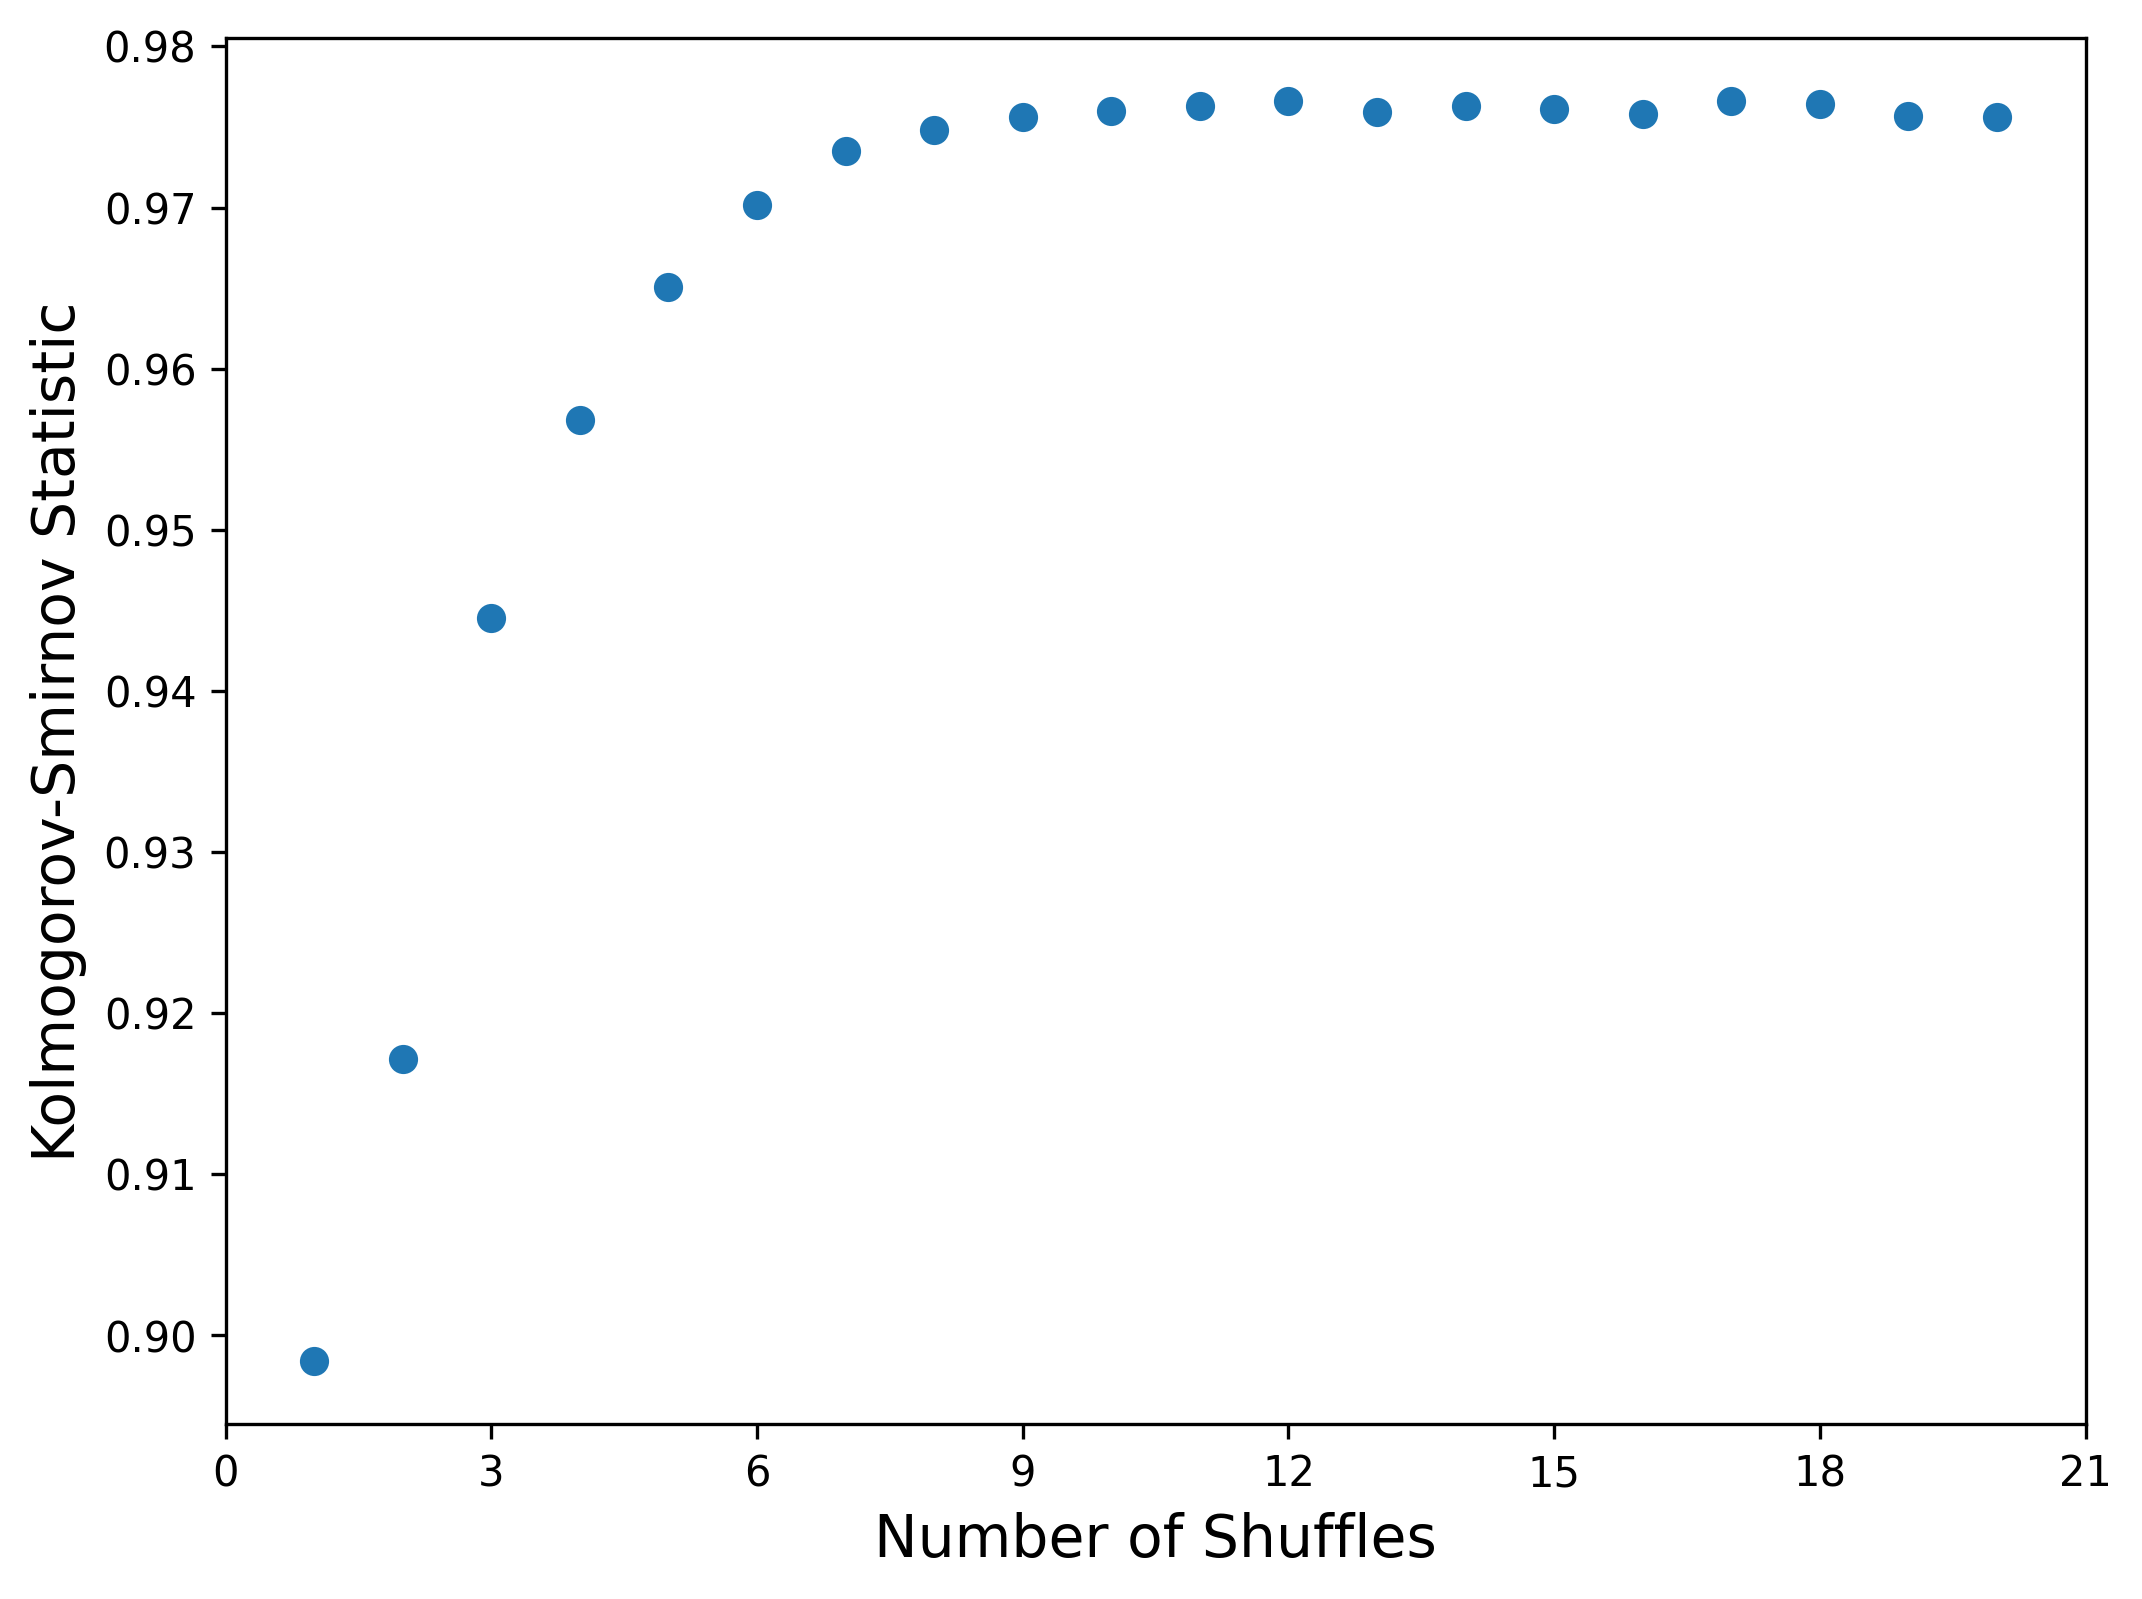

In [153]:
fs = 14
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.scatter(range(1, max_num_shuffles + 1), kstests, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Kolmogorov-Smirnov Statistic', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();

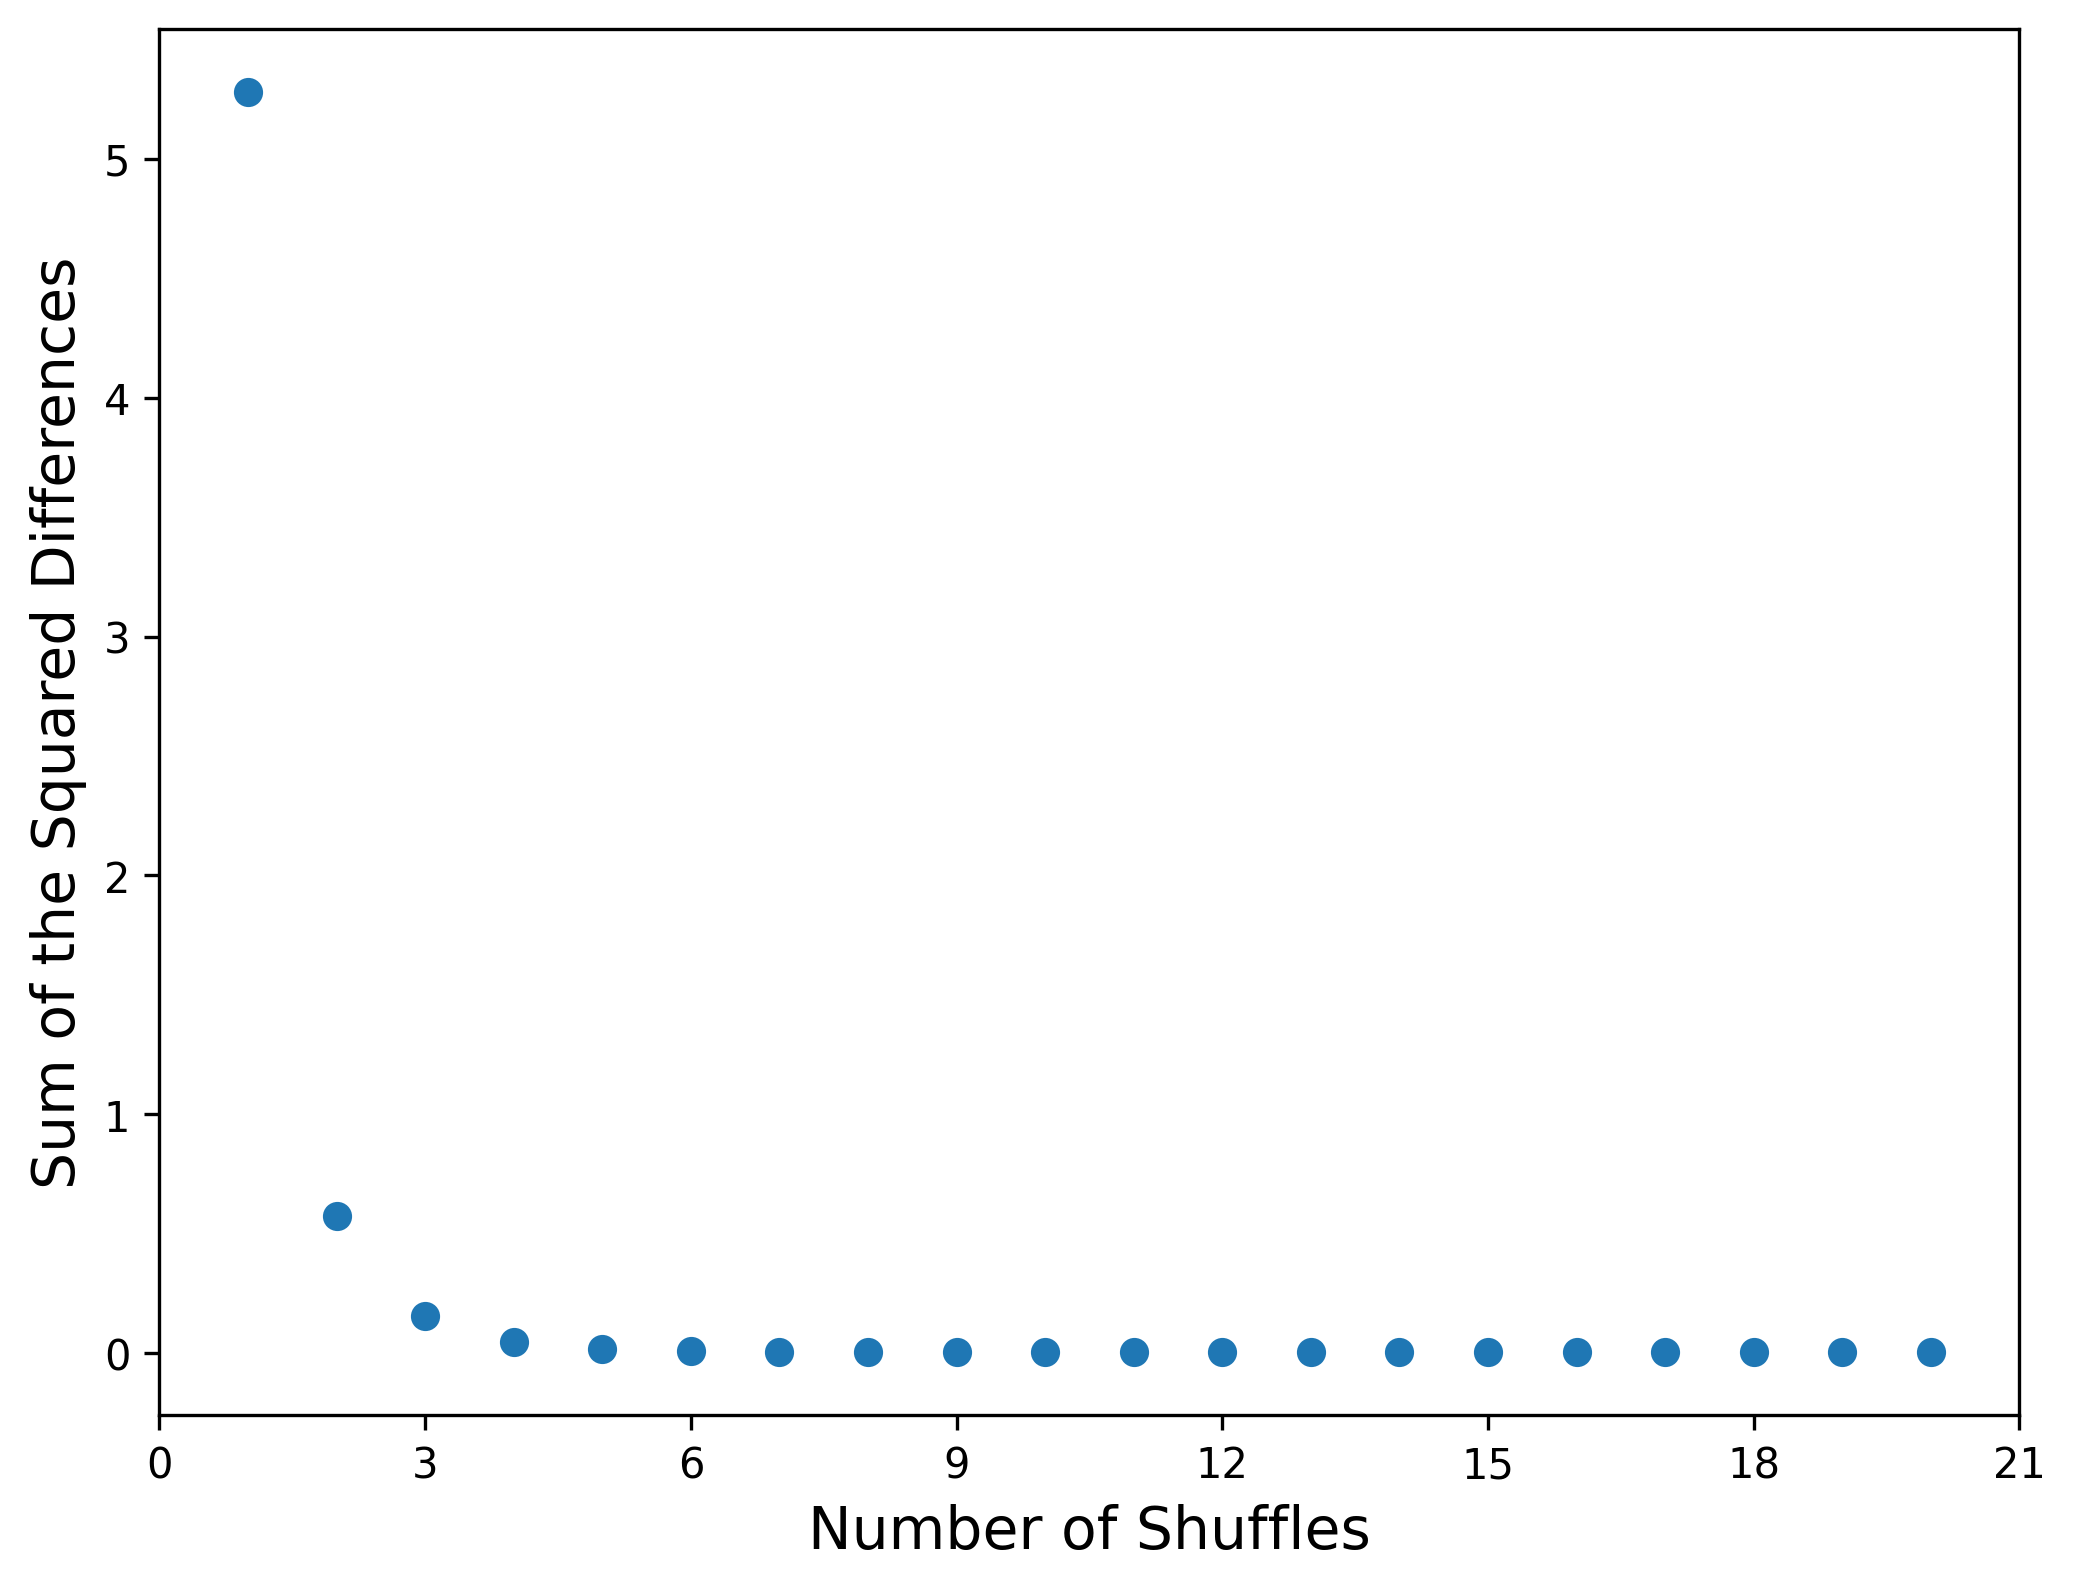

In [154]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.scatter(range(1, max_num_shuffles + 1), sums_squared, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Sum of the Squared Differences', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();

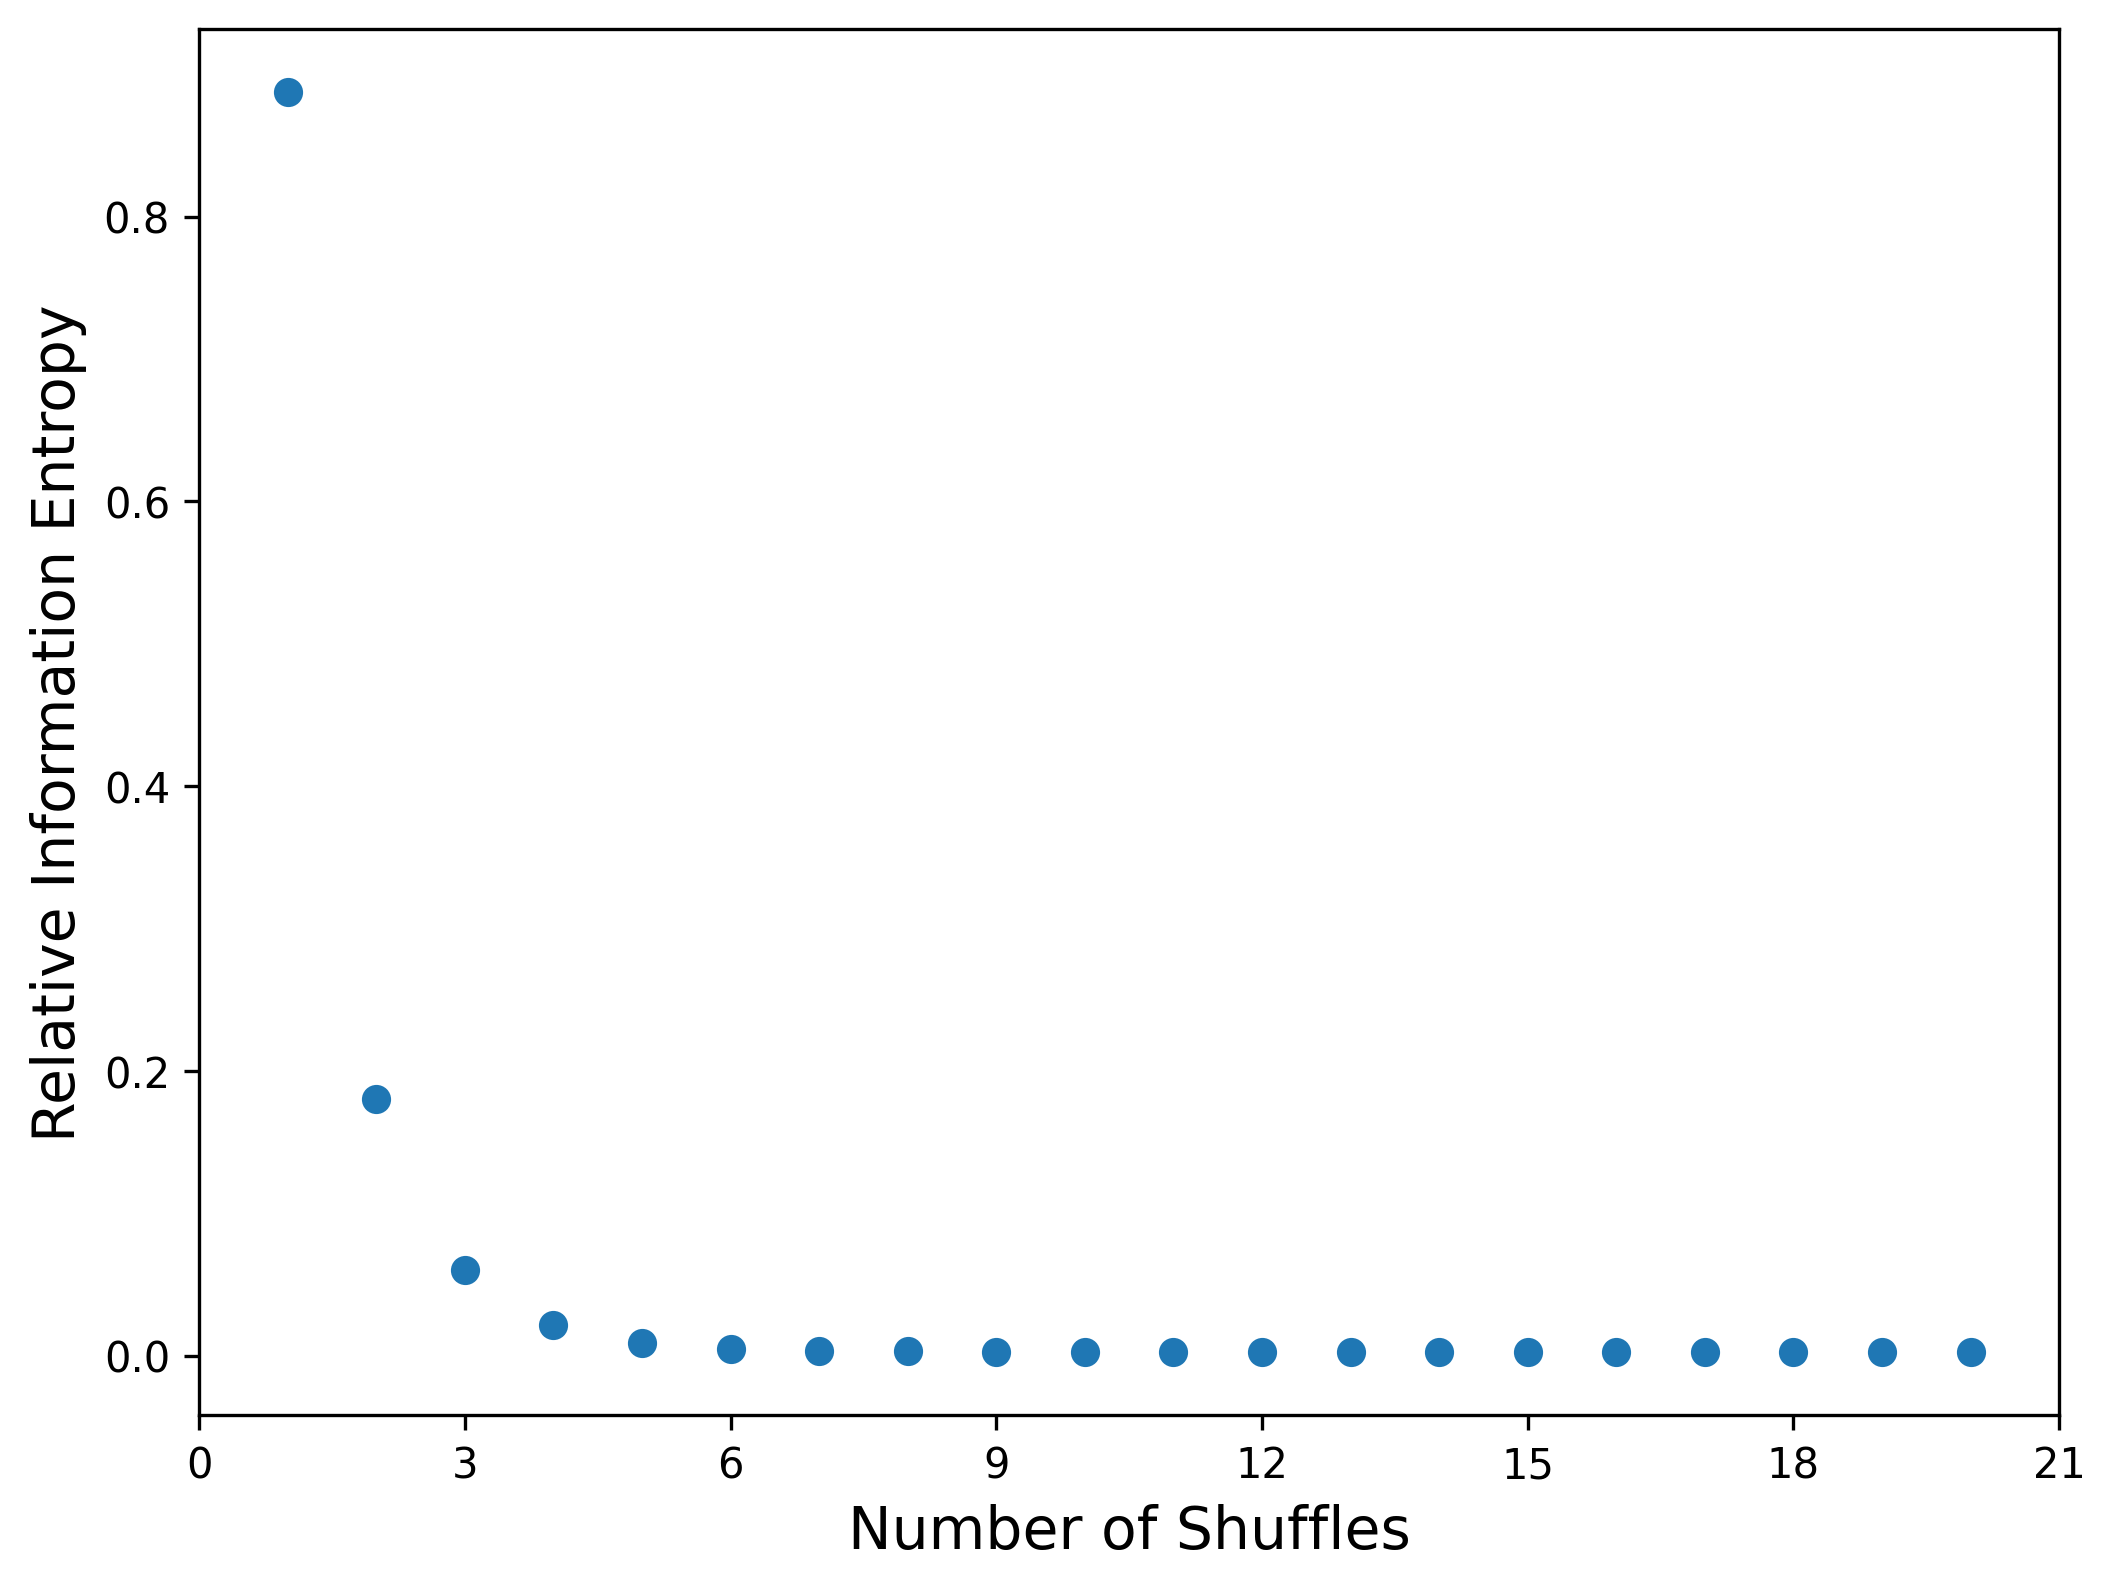

In [155]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.scatter(range(1, max_num_shuffles + 1), entropies, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Relative Information Entropy', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();